In [1]:
# Make sure to install the requirements with pip install -r requirements.txt
import os
os.chdir('..')
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
from lib.model import get_model_and_optim
from lib.data import prepare_nuclear_data, semi_empirical_mass_formula
from lib.utils import  PlottingContext, IO, get_rms
from sklearn.decomposition import PCA
import seaborn as sns
sns.set_style('white')
sns.set_context('paper')
import glob
from collections import defaultdict
from copy import deepcopy

In [2]:
import re
torch.inference_mode()
# locations = glob.glob('/checkpoint/nolte/nuclr/long-runs/*')
locations = glob.glob('/checkpoint/nolte/NuCLR-MechInterp-results/*')
print(locations)
# get train fracs for full
# all_re = re.compile(".*/epochs-50000-binding100\+.*-seed(\d)-dataseed\d-trainfrac(\d+\.\d+).*ge8")
all_re = re.compile("epochs-200000-binding100\+.*-seed(\d)-dataseed\d-trainfrac(\d+\.\d+)-nuclei_ge8-hiddendim1024-LR0.0003")
binding_re = re.compile(".*/long_run-binding100-seed0-trainfrac(\d+\.\d+)")
binding_semf_re = re.compile(".*/long_run-binding_semf100-seed0-trainfrac(\d+\.\d+)")
# get train fracs for partial
all_trainfracs = {}
for loc in locations:
    match = all_re.search(loc)
    if match is not None:
      # if float(match.group(2)) > 0.7: continue
      all_trainfracs[(int(match.group(1)), float(match.group(2)))] = loc
print(len(all_trainfracs))

['/checkpoint/nolte/NuCLR-MechInterp-results/long_run-binding_semf100-seed0', '/checkpoint/nolte/NuCLR-MechInterp-results/long_run-binding100-seed0', '/checkpoint/nolte/NuCLR-MechInterp-results/long_run-z1-seed0', '/checkpoint/nolte/NuCLR-MechInterp-results/long_run-n1-seed0', '/checkpoint/nolte/NuCLR-MechInterp-results/long_run-radius0.02-seed0', '/checkpoint/nolte/NuCLR-MechInterp-results/long_run-qa200-seed0', '/checkpoint/nolte/NuCLR-MechInterp-results/long_run-qbm200-seed0', '/checkpoint/nolte/NuCLR-MechInterp-results/long_run-qbm_n200-seed0', '/checkpoint/nolte/NuCLR-MechInterp-results/long_run-qec200-seed0', '/checkpoint/nolte/NuCLR-MechInterp-results/long_run-sn200-seed0', '/checkpoint/nolte/NuCLR-MechInterp-results/long_run-sp200-seed0', '/checkpoint/nolte/NuCLR-MechInterp-results/long_run-binding100+z1+n1+radius0.02+qa200+qbm200+qbm_n200+qec200+sn200+sp200-seed0', '/checkpoint/nolte/NuCLR-MechInterp-results/trainfrac_0.8', '/checkpoint/nolte/NuCLR-MechInterp-results/trainfrac

In [3]:
def get_all_checkpoints_from(dir):
    checkpoints = {}
    for ckpt in os.listdir(dir):
        if ckpt.endswith('.pt') and "-" in ckpt:
            epoch = int(ckpt.split('-')[1].split('.')[0])
            if epoch % 5000 == 0: # WARNING
                checkpoints[epoch] = ckpt
    return checkpoints

def get_preds(X, model, batch=10000):
    preds = torch.zeros(X.shape[0], 1).to(X.device)
    with torch.no_grad():
        for i in range(0, X.shape[0], batch):
            preds_ = model(X[i:i+batch])
            # preds_ = torch.gather(preds_, 1, X[i:i+batch, [2]])
            preds[i:i+batch] = preds_
    return preds

def fix_val_mask_to_include_only_used_elements(data):
    non_nan_targets = ~torch.isnan(data.y.view(-1))
    X_train = data.X[data.train_mask & non_nan_targets]
    Z_train = X_train[:, 0].unique() 
    N_train = X_train[:, 1].unique()
    return data.val_mask & torch.isin(data.X[:, 0], Z_train) & torch.isin(data.X[:, 1], N_train)


def get_rms(model, data, split="all"):
    #filter out nans
    non_nan_targets = ~torch.isnan(data.y.view(-1))

    if split == "all":
        mask = torch.ones_like(data.y.view(-1), dtype=torch.bool)
    elif split == "train":
        mask = data.train_mask
    elif split == "val":
        mask = fix_val_mask_to_include_only_used_elements(data)
        print(mask.float().mean().item(), end="\r")

    X = data.X[non_nan_targets & mask]
    y = data.y[non_nan_targets & mask]
    

    preds = get_preds(X, model)
    rms = {}
    for i, task_name in enumerate(data.output_map):
        task_mask = X[:, 2] == i
        rms[task_name] = torch.sqrt(torch.mean((preds[task_mask] - y[task_mask])**2)).item()
    return rms

In [4]:
location = all_trainfracs[(2, .9)]

In [5]:
args = IO.load_args(f"{location}/args.yaml")
args.DEV = "cuda:1"
data = prepare_nuclear_data(args)
model = get_model_and_optim(data, args)[0]
model.load_state_dict(torch.load(f"{location}/ckpts/model.pt"))

checkpoints = get_all_checkpoints_from(location + '/ckpts')

last_checkpoint = max(checkpoints.keys())

task_rms_values = {}
for epoch, ckpt in checkpoints.items():
    model.load_state_dict(torch.load(f"{location}/ckpts/{ckpt}"))
    task_rms_values[epoch] = get_rms(model, data, "val")["binding"]

task_rms_values

{0: 1021354.1875,
 10000: 2453.35888671875,
 20000: 2238.18408203125,
 30000: 2253.329833984375,
 40000: 1569.4033203125,
 50000: 1329.8492431640625,
 60000: 1181.241455078125,
 70000: 1127.98876953125,
 80000: 1697.0167236328125,
 90000: 927.6207885742188,
 100000: 824.619140625,
 110000: 1252.46435546875,
 120000: 685.9503173828125,
 130000: 709.5668334960938,
 140000: 657.9586791992188,
 150000: 630.3558349609375,
 160000: 624.388427734375,
 170000: 1307.878173828125,
 180000: 560.6163940429688,
 190000: 688.1664428710938}

In [6]:
model.cpu().load_state_dict(torch.load(f"{location}/ckpts/{checkpoints[last_checkpoint]}", map_location="cpu"))
model.requires_grad_(False)
args = IO.load_args(f"{location}/args.yaml")
args.DEV = "cpu"
data = prepare_nuclear_data(args)

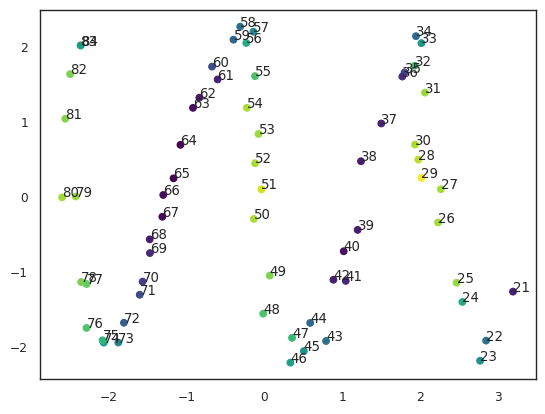

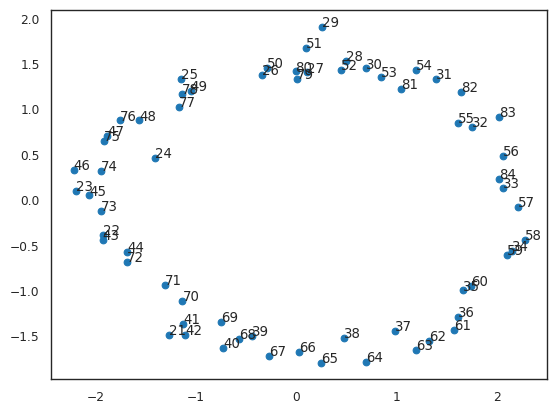

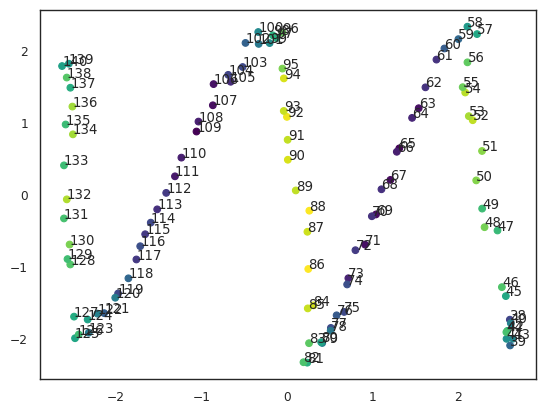

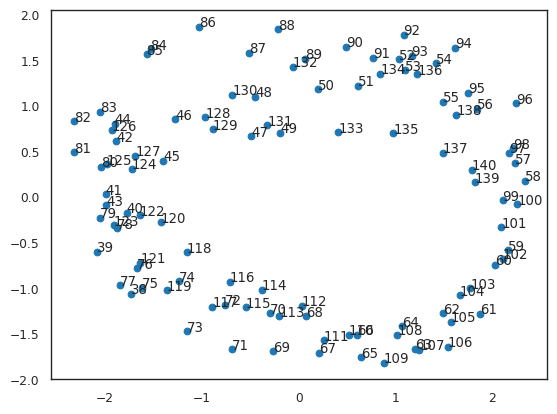

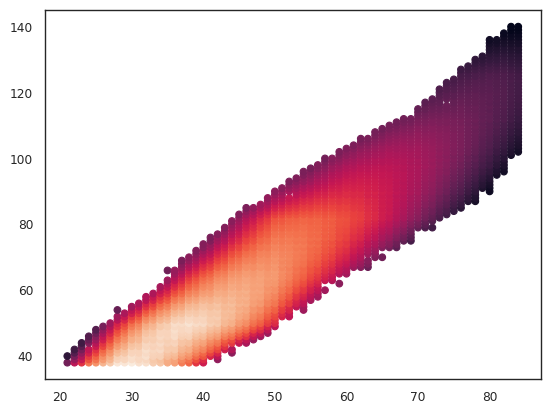

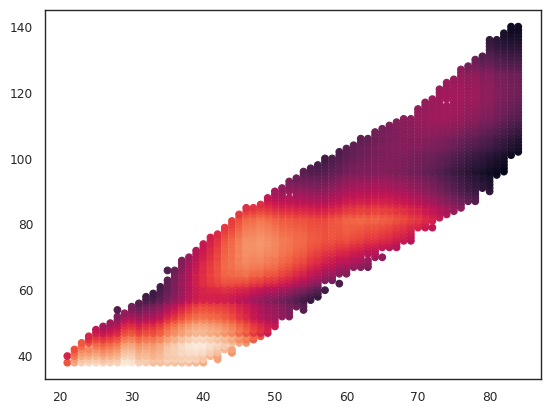

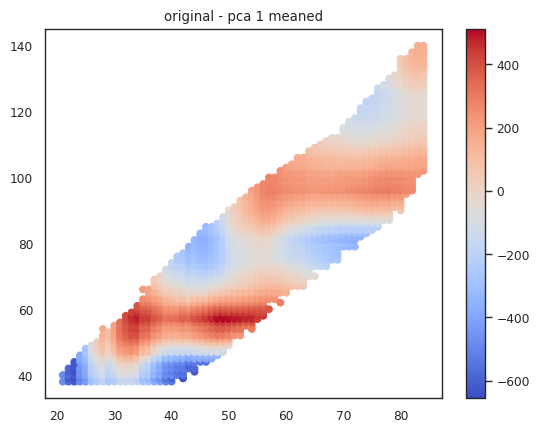

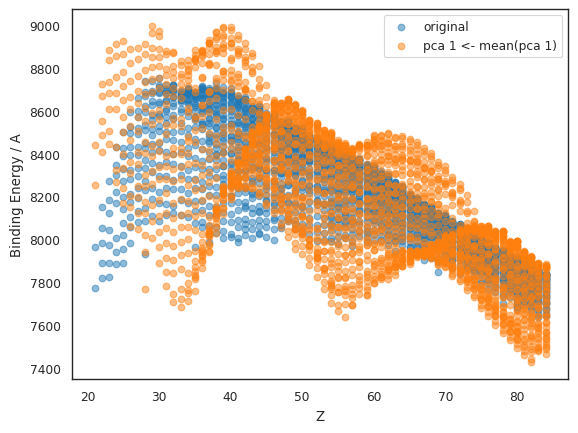

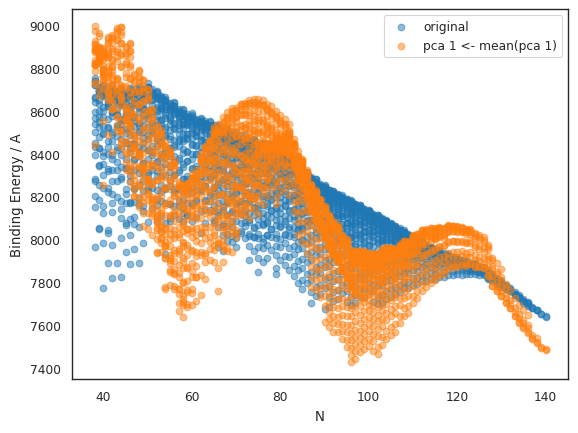

In [20]:
start_z = 21
end_z = 85
pca_z = PCA(n_components=end_z - start_z)
emb_pca_z = pca_z.fit_transform(model.emb[0][start_z:end_z].detach().cpu().numpy())
plt.scatter(emb_pca_z[:, 0], emb_pca_z[:, 1], c=emb_pca_z[:, 2], cmap='viridis')
for i, emb in enumerate(emb_pca_z):
  plt.annotate(i+start_z, emb[:2])
plt.show()

plt.scatter(emb_pca_z[:, 1], emb_pca_z[:, 2])
for i, emb in enumerate(emb_pca_z):
  plt.annotate(i+start_z, emb[[1,2]])
plt.show()

start_n = 38
end_n = 141
pca_n = PCA(n_components=end_n - start_n)
emb_pca_n = pca_n.fit_transform(model.emb[1][start_n:end_n].detach().cpu().numpy())
plt.scatter(emb_pca_n[:, 0], emb_pca_n[:, 1], c=emb_pca_n[:, 2], cmap='viridis')
for i, emb in enumerate(emb_pca_n):
  plt.annotate(i+start_n, emb[:2])
plt.show()

plt.scatter(emb_pca_n[:, 1], emb_pca_n[:, 2])
for i, emb in enumerate(emb_pca_n):
  plt.annotate(i+start_n, emb[[1,2]])
plt.show()

# TODO comment this back in
emb_pca_z[:,[1]] = emb_pca_z[:,[1]].mean(0)
emb_pca_n[:,[1]] = emb_pca_n[:,[1]].mean(0)

model_emb = deepcopy(model)
model_emb.emb[0][start_z:end_z] = torch.tensor(pca_z.inverse_transform(emb_pca_z))
model_emb.emb[1][start_n:end_n] = torch.tensor(pca_n.inverse_transform(emb_pca_n))
model_emb.readout = model.readout

sel = (data.X[:,0] >= start_z) & (data.X[:,0] < end_z) & (data.X[:,1] >= start_n) & (data.X[:,1] < end_n)  & (data.X[:,2] == 0)# & ((data.X[:,0] == 50) | (data.X[:,0] == 60))
X = data.X[sel]
output_emb = model_emb(X) / X.sum(1, keepdim=True)
output = model(X) / X.sum(1, keepdim=True)

plt.scatter(X[:, 0], X[:,1], c=output.numpy())
plt.show()
plt.scatter(X[:, 0], X[:,1], c=output_emb.numpy())
plt.show()

plt.scatter(X[:, 0], X[:,1], c=output.numpy() - output_emb.numpy(), cmap="coolwarm")
plt.colorbar()
plt.title("original - pca 1 meaned")
plt.show()

plt.scatter(X[:, 0], output.detach().cpu().numpy(), label='original', alpha=.5)
plt.scatter(X[:, 0], output_emb.detach().cpu().numpy(), label='pca 1 <- mean(pca 1)', alpha=.5)
plt.xlabel("Z")
plt.ylabel("Binding Energy / A")
plt.legend()
plt.show()

plt.scatter(X[:, 1], output.detach().cpu().numpy(), label='original', alpha=.5)
plt.scatter(X[:, 1], output_emb.detach().cpu().numpy(), label='pca 1 <- mean(pca 1)', alpha=.5)
plt.xlabel("N")
plt.ylabel("Binding Energy / A")
plt.legend()
plt.show()

Epoch [100/3000], Loss: 0.9428
Epoch [200/3000], Loss: 0.4358
Epoch [300/3000], Loss: 0.2141


Epoch [400/3000], Loss: 0.1102
Epoch [500/3000], Loss: 0.0837
Epoch [600/3000], Loss: 0.0798
Epoch [700/3000], Loss: 0.0793
Epoch [800/3000], Loss: 0.0793
Epoch [900/3000], Loss: 0.0793
Epoch [1000/3000], Loss: 0.0793
Epoch [1100/3000], Loss: 0.0793
Epoch [1200/3000], Loss: 0.0793
Epoch [1300/3000], Loss: 0.0793
Epoch [1400/3000], Loss: 0.0793
Epoch [1500/3000], Loss: 0.0793
Epoch [1600/3000], Loss: 0.0793
Epoch [1700/3000], Loss: 0.0793
Epoch [1800/3000], Loss: 0.0793
Epoch [1900/3000], Loss: 0.0793
Epoch [2000/3000], Loss: 0.0793
Epoch [2100/3000], Loss: 0.0793
Epoch [2200/3000], Loss: 0.0793
Epoch [2300/3000], Loss: 0.0793
Epoch [2400/3000], Loss: 0.0793
Epoch [2500/3000], Loss: 0.0793
Epoch [2600/3000], Loss: 0.0793
Epoch [2700/3000], Loss: 0.0793
Epoch [2800/3000], Loss: 0.0793
Epoch [2900/3000], Loss: 0.0793
Epoch [3000/3000], Loss: 0.0793


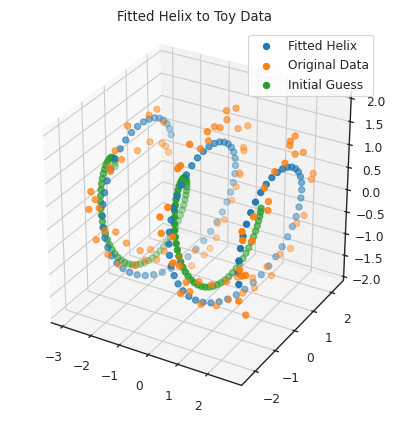

Epoch [100/3000], Loss: 0.9408
Epoch [200/3000], Loss: 0.4621
Epoch [300/3000], Loss: 0.2690
Epoch [400/3000], Loss: 0.1737
Epoch [500/3000], Loss: 0.1385
Epoch [600/3000], Loss: 0.1297
Epoch [700/3000], Loss: 0.1281
Epoch [800/3000], Loss: 0.1279
Epoch [900/3000], Loss: 0.1279
Epoch [1000/3000], Loss: 0.1279
Epoch [1100/3000], Loss: 0.1279
Epoch [1200/3000], Loss: 0.1279
Epoch [1300/3000], Loss: 0.1279
Epoch [1400/3000], Loss: 0.1279
Epoch [1500/3000], Loss: 0.1279
Epoch [1600/3000], Loss: 0.1279
Epoch [1700/3000], Loss: 0.1279
Epoch [1800/3000], Loss: 0.1279
Epoch [1900/3000], Loss: 0.1279
Epoch [2000/3000], Loss: 0.1279
Epoch [2100/3000], Loss: 0.1279
Epoch [2200/3000], Loss: 0.1279
Epoch [2300/3000], Loss: 0.1279
Epoch [2400/3000], Loss: 0.1279
Epoch [2500/3000], Loss: 0.1279
Epoch [2600/3000], Loss: 0.1279
Epoch [2700/3000], Loss: 0.1279
Epoch [2800/3000], Loss: 0.1279
Epoch [2900/3000], Loss: 0.1279
Epoch [3000/3000], Loss: 0.1279


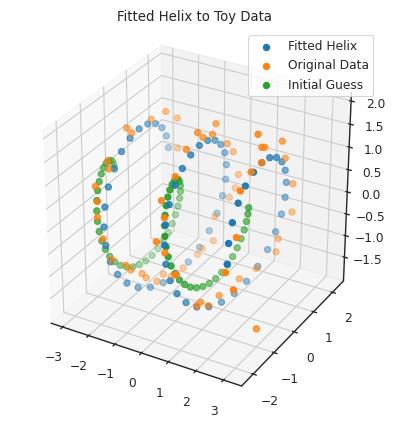

In [27]:

def find_orthonormal_basis(a):
    """
    Find two orthonormal vectors that are perpendicular to the vector a in PyTorch.
    """
    if a[0] != 0 or a[1] != 0:
        v1 = torch.tensor([-a[1], a[0], 0], dtype=torch.float32)
    else:
        v1 = torch.tensor([0, -a[2], a[1]], dtype=torch.float32)
    v1 = v1 / torch.norm(v1)
    v2 = torch.cross(a, v1)
    return v1, v2

def helix(t, R, F, P, axis, start, phase, final_linear):
    """
    Parametric equations for a 3D spiral (helix) around a specified axis in PyTorch.
    """
    # Normalize the axis
    a = axis / torch.norm(axis)
    
    # Find two orthonormal vectors perpendicular to the axis
    u, v = find_orthonormal_basis(a)

    # Circular motion around the axis
    V_perp = R * (torch.cos(2*torch.pi * F * t + phase)[:, None] * u + torch.sin(2*torch.pi*F * t + phase)[:, None] * v)

    # Movement along the axis
    V_axis = P * t[:, None] * a

    return (V_perp + V_axis + start) @ final_linear


# Toy data generation
# t = torch.linspace(0, 5, len(emb_pca))
# R_true = 1
# F_true = 0.3 * 2 * torch.pi
# P_true = 4
# axis_true = torch.tensor([1., 0., 1.], dtype=torch.float32)  # Arbitrary axis
# start_point = torch.tensor([0., 0., 0.], dtype=torch.float32)  # Arbitrary start point

# Generating the helix data
# data = helix(t, R_true, F_true, P_true, axis_true, start_point)
emb_pca_z = pca_z.transform(model.emb[0][start_z:end_z].detach().cpu().numpy())
emb_pca_n = pca_n.transform(model.emb[1][start_n:end_n].detach().cpu().numpy())

def get_spiral_preds(emb_pca):
  data_spiral = torch.tensor(emb_pca[:,:3], requires_grad=False)

  # Parameters as PyTorch tensors
  t = torch.linspace(0, 1, len(data_spiral), requires_grad=False)
  R = torch.tensor(1.0, requires_grad=True)  # Radius
  F = torch.tensor(2., requires_grad=True)  # Frequency
  P = torch.tensor(5., requires_grad=True)  # Pitch
  axis = torch.tensor([1.,0.,0.], requires_grad=True, dtype=torch.float32)  # Axis of the spiral
  starto = torch.tensor([-3.,-1,0.], requires_grad=True, dtype=torch.float32)  # Start point of the spiral
  phase = torch.tensor(0.5, requires_grad=True)  # Phase shift of the spiral
  final_linear = torch.eye(3, requires_grad=True, dtype=torch.float32)

  with torch.no_grad():
    initial_guess = helix(t, R, F, P, axis, starto, phase, final_linear)

  # # Optimizer
  optimizer = torch.optim.Adam([R, F, P, axis, starto, final_linear], lr=0.01)

  # Loss function
  def loss_fn(predicted, target):
      return ((predicted - target)**2).mean()

  # Training loop
  epochs = 3000
  for epoch in range(epochs):
      optimizer.zero_grad()
      predicted = helix(t, R, F, P, axis, starto, phase, final_linear)
      loss = loss_fn(predicted, data_spiral)
      loss.backward()
      optimizer.step()

      if (epoch+1) % 100 == 0:
          print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

  # Plotting the results
  predicted = helix(t, R, F, P, axis, starto, phase, final_linear).detach().numpy()
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d', aspect='equal')
  ax.scatter(predicted[:, 0], predicted[:, 1], predicted[:, 2], label='Fitted Helix')
  ax.scatter(data_spiral[:, 0], data_spiral[:, 1], data_spiral[:, 2], label='Original Data')
  ax.scatter(initial_guess[:, 0], initial_guess[:, 1], initial_guess[:, 2], label='Initial Guess')
  # plot the vectors
  plt.title('Fitted Helix to Toy Data')
  plt.legend()
  plt.show()
  return predicted

predicted_n = get_spiral_preds(emb_pca_n)
predicted_z = get_spiral_preds(emb_pca_z)

In [28]:
from copy import deepcopy
with torch.no_grad():
  model_spiral = deepcopy(model)
  model_spiral.readout = model.readout

  spiral_embs_n = emb_pca_n.copy()
  spiral_embs_n[:, :3] = predicted_n
  spiral_embs_n = pca_n.inverse_transform(spiral_embs_n)
  spiral_embs_n = torch.tensor(spiral_embs_n, device=args.DEV).float()
  model_spiral.emb[1][start_n:end_n] = spiral_embs_n

  spiral_embs_z = emb_pca_z.copy()
  spiral_embs_z[:, :3] = predicted_z
  spiral_embs_z = pca_z.inverse_transform(spiral_embs_z)
  spiral_embs_z = torch.tensor(spiral_embs_z, device=args.DEV).float()
  model_spiral.emb[0][start_z:end_z] = spiral_embs_z

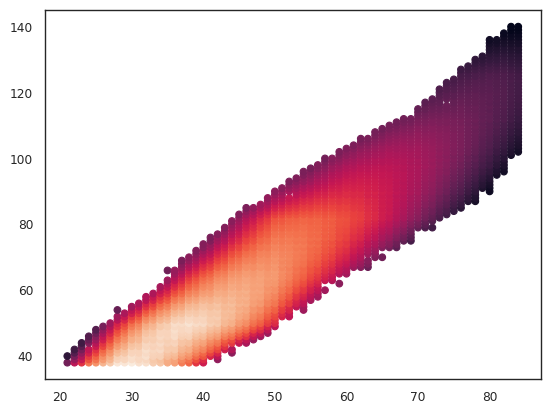

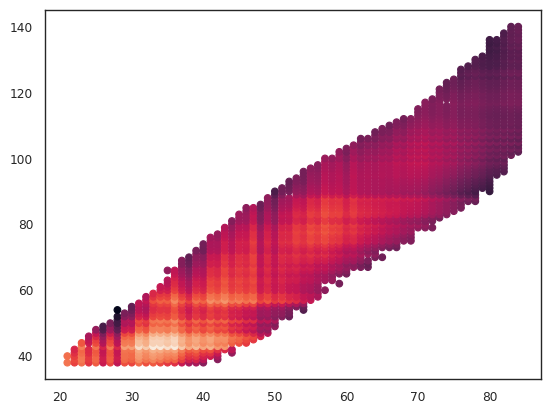

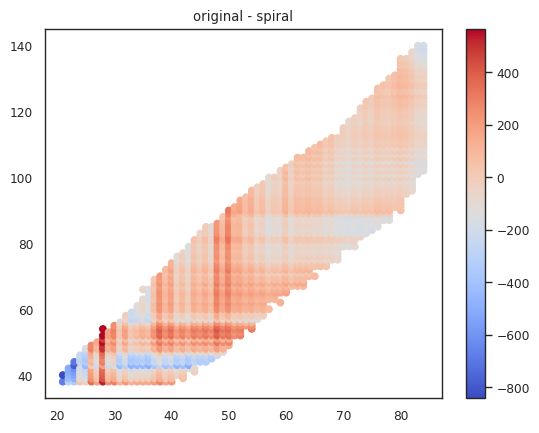

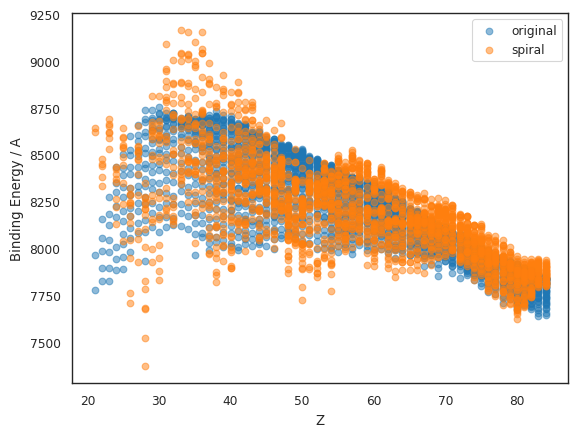

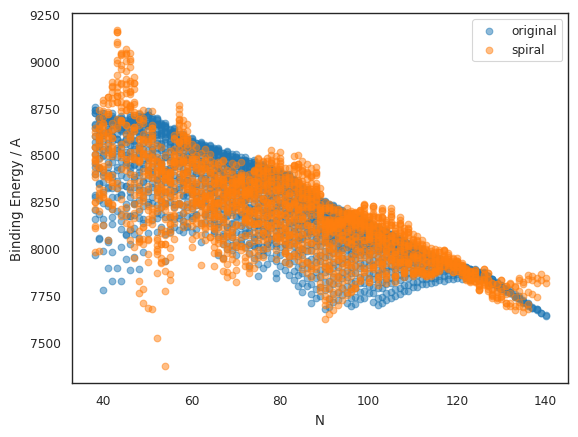

In [29]:
output_spiral = model_spiral(X) / X.sum(1, keepdim=True)
output = model(X) / X.sum(1, keepdim=True)

plt.scatter(X[:, 0], X[:,1], c=output.numpy())
plt.show()
plt.scatter(X[:, 0], X[:,1], c=output_spiral.numpy())
plt.show()

plt.scatter(X[:, 0], X[:,1], c=output.numpy() - output_spiral.numpy(), cmap="coolwarm")
plt.colorbar()
plt.title("original - spiral")
plt.show()

plt.scatter(X[:, 0], output.detach().cpu().numpy(), label='original', alpha=.5)
plt.scatter(X[:, 0], output_spiral.detach().cpu().numpy(), label='spiral', alpha=.5)
plt.xlabel("Z")
plt.ylabel("Binding Energy / A")
plt.legend()
plt.show()

plt.scatter(X[:, 1], output.detach().cpu().numpy(), label='original', alpha=.5)
plt.scatter(X[:, 1], output_spiral.detach().cpu().numpy(), label='spiral', alpha=.5)
plt.xlabel("N")
plt.ylabel("Binding Energy / A")
plt.legend()
plt.show()

In [71]:
#prepare some good X
model = model.cpu()
# N = 50
Z = 82
X = data.X[(data.X[:,0] == 82) & (data.X[:,2] == 0)].cpu()
num_input = 80
start = 80
X = torch.zeros((num_input, 3), dtype=torch.long)
# X[:,0] = torch.arange(start, num_input+start)
# X[:,1] = N
X[:,0] = Z
X[:,1] = torch.arange(start, num_input + start)

In [72]:
from copy import deepcopy
with torch.no_grad():
  pca = PCA(n_components=1)
  pca.fit(model.emb[0].detach().cpu().numpy())
  emb_pca = pca.transform(model.emb[0].detach().cpu().numpy())

  emb_pca = pca.inverse_transform(emb_pca)
  emb_pca = torch.tensor(emb_pca, device="cpu").float()
  emb_pca

  model_emb0 = deepcopy(model).cpu()
  model_emb0.emb[0] = emb_pca
  model_emb0.readout = model.readout

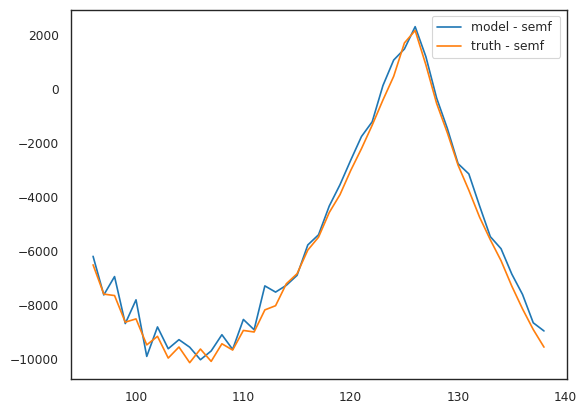

In [74]:
with torch.no_grad():
  model_output = (model(X)).view(-1).numpy()
  model_emb0_output = (model_emb0(X)).view(-1).numpy()
  # plt.plot(X[:,0].numpy(), model_output - model_emb0_output, label="diff model")
  # plt.plot(X[:,0].numpy(), model_output, label="full model")jkj
  # plt.plot(X[:,0].numpy(), model_emb0_output, label="emb0 model")
  semf = semi_empirical_mass_formula(X[:,0].numpy(), X[:,1].numpy()) * (X[:,0] + X[:,1]).numpy()
  # plt.plot(X[:,0].numpy(), semf.numpy(), label="SEMF")
  plt.plot(X[:,1].numpy(), model_output - semf, label="model - semf ")
  sel = (data.X[:,0] == Z) & (data.X[:,2] == 0)
  plt.plot(data.X[sel][:,1].cpu().numpy(), data.y[sel].cpu().numpy()[:,0]-semf, label="truth - semf")
  # truth = data.y[(data.X[:,1] == N) & (data.X[:,2] == 0)].cpu()
  # plt.plot(X[:,0].numpy(), truth.numpy(), label="truth")
  plt.legend()

tensor([[1304070.0000],
        [1314306.0000],
        [1326740.2500],
        [1336425.0000],
        [1348462.6250],
        [1357862.3750],
        [1369748.8750],
        [1378811.3750],
        [1390422.2500],
        [1399111.1250],
        [1410500.0000],
        [1418981.8750],
        [1429969.0000],
        [1438268.1250],
        [1448879.5000],
        [1456789.7500],
        [1467216.5000],
        [1474867.2500],
        [1485018.3750],
        [1492517.7500],
        [1502333.2500],
        [1509625.8750],
        [1519116.7500],
        [1526238.7500],
        [1535431.8750],
        [1542332.6250],
        [1551216.5000],
        [1558002.1250],
        [1566487.5000],
        [1573150.6250],
        [1581179.1250],
        [1587409.7500],
        [1595163.7500],
        [1601159.0000],
        [1608651.2500],
        [1614320.1250],
        [1621049.5000],
        [1624662.5000],
        [1629511.7500],
        [1632917.0000],
        [1637790.0000],
        [1640947